## Dataset

### Load Dataset(From 9 Environments)

In [1]:
import pandas as pd
from pathlib import Path

# -----------------------------
# File Paths & Column Settings
# -----------------------------
MOTION_FILES = [
    "datasets/090_Tm_7.5_HS_3.5.out",
    "datasets/090_Tm_9.5_HS_3.5.out",
    "datasets/090_Tm_11.5_HS_3.5.out",
    "datasets/135_Tm_7.5_HS_3.5.out",
    "datasets/135_Tm_9.5_HS_3.5.out",
    "datasets/135_Tm_11.5_HS_3.5.out",
    "datasets/180_Tm_7.5_HS_3.5.out",
    "datasets/180_Tm_9.5_HS_3.5.out",
    "datasets/180_Tm_11.5_HS_3.5.out"
]

WAVE_FILES = [
    "datasets/Wave_090_Tm_7.5_HS_3.5.out",
    "datasets/Wave_090_Tm_9.5_HS_3.5.out",
    "datasets/Wave_090_Tm_11.5_HS_3.5.out",
    "datasets/Wave_135_Tm_7.5_HS_3.5.out",
    "datasets/Wave_135_Tm_9.5_HS_3.5.out",
    "datasets/Wave_135_Tm_11.5_HS_3.5.out",
    "datasets/Wave_180_Tm_7.5_HS_3.5.out",
    "datasets/Wave_180_Tm_9.5_HS_3.5.out",
    "datasets/Wave_180_Tm_11.5_HS_3.5.out"
]

MOTION_COLUMNS = ["t(s)", "x1(m)", "x2(m)", "x3(m)", "x4(deg)", "x5(deg)", "x6(deg)"]
WAVE_COLUMNS = ["t(s)", "z(m)"]

# -----------------------------
# Read Motion Files
# -----------------------------
def read_motion_files(file_list):
    dataframes = []
    for idx, file in enumerate(file_list, start=1):
        df = pd.read_csv(file, sep=r'\s+', skiprows=1, header=None)
        df.columns = MOTION_COLUMNS
        df["file_index"] = idx
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# -----------------------------
# Read Wave Files
# -----------------------------
def read_wave_files(file_list):
    dataframes = []
    for idx, file in enumerate(file_list, start=1):
        df = pd.read_csv(file, sep=r'\s+', skiprows=1, header=None)
        df.columns = WAVE_COLUMNS
        df["file_index"] = idx
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# -----------------------------
# Print Row Count by File
# -----------------------------
def count_file_rows(file_list):
    print("=== Row count per file ===")
    for file in file_list:
        count = pd.read_csv(file, sep=r'\s+', skiprows=1).shape[0]
        print(f"{file}: {count} rows")

# -----------------------------
# Align File Indices
# -----------------------------
def align_file_index(motion_df, wave_df):
    # Re-assign file_index starting from 0
    motion_df["file_index"] = motion_df.groupby("file_index").ngroup()
    wave_df["file_index"] = wave_df.groupby("file_index").ngroup()
    return motion_df, wave_df

# -----------------------------
# Main Execution
# -----------------------------

# 1. Check row count per file (optional)
# count_file_rows(MOTION_FILES + WAVE_FILES)

# 2. Load data
motion_df = read_motion_files(MOTION_FILES)
wave_df = read_wave_files(WAVE_FILES)

# 3. Align file indices
motion_df, wave_df = align_file_index(motion_df, wave_df)

# 4. Merge motion and wave data on timestamp and file index
merged_df = pd.merge(motion_df, wave_df, on=["t(s)", "file_index"], how="inner")

# 5. Summary
print("\n=== Sample of Merged Data ===")
print(merged_df.info())

# 6. Check unique file index counts
print(f"\nMotion file_index count: {motion_df['file_index'].nunique()}")
print(f"Wave file_index count:   {wave_df['file_index'].nunique()}")



=== Sample of Merged Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   t(s)        900000 non-null  float64
 1   x1(m)       900000 non-null  float64
 2   x2(m)       900000 non-null  float64
 3   x3(m)       900000 non-null  float64
 4   x4(deg)     900000 non-null  float64
 5   x5(deg)     900000 non-null  float64
 6   x6(deg)     900000 non-null  float64
 7   file_index  900000 non-null  int64  
 8   z(m)        900000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 61.8 MB
None

Motion file_index count: 9
Wave file_index count:   9


In [2]:
from sklearn.preprocessing import StandardScaler

def normalize_all(df):
    """
    Normalize all numeric features in the dataframe except for time and file index columns.

    Parameters:
        df (pd.DataFrame): Input dataframe containing motion and wave data.

    Returns:
        normalized_df (pd.DataFrame): DataFrame with normalized feature columns.
        scaler (StandardScaler): Fitted StandardScaler for reuse on other data (e.g., test set).
    """
    # Select all columns except 't(s)' and 'file_index' for normalization
    feature_columns = [col for col in df.columns if col not in ["t(s)", "file_index"]]

    # Initialize and fit the scaler on selected feature columns
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df[feature_columns])

    # Create a copy of the original dataframe and update normalized values
    normalized_df = df.copy()
    normalized_df[feature_columns] = scaled_values

    return normalized_df, scaler

# Apply normalization and save the scaler for later use
df_merged, scaler = normalize_all(merged_df)


In [3]:
import pandas as pd

def sequential_split_by_file_index(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Sequentially splits the DataFrame by file_index into train, validation, and test sets.
    The time series within each file_index is sorted by time and truncated to multiples of 100.
    """
    train_list, val_list, test_list = [], [], []

    for file_idx, group_df in df.groupby("file_index"):
        group_df = group_df.sort_values("t(s)").reset_index(drop=True)
        n = len(group_df)

        # Compute split lengths and round down to nearest 100
        n_train = int(n * train_ratio) // 100 * 100
        n_val = int(n * val_ratio) // 100 * 100
        n_test = (n - n_train - n_val) // 100 * 100

        # Define slicing indices
        train_end = n_train
        val_end = train_end + n_val
        test_end = val_end + n_test  # Remaining tail is discarded

        train_list.append(group_df.iloc[:train_end])
        val_list.append(group_df.iloc[train_end:val_end])
        test_list.append(group_df.iloc[val_end:test_end])

    train_df = pd.concat(train_list).reset_index(drop=True)
    val_df = pd.concat(val_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)

    return train_df, val_df, test_df


# Apply the split
train_df, val_df, test_df = sequential_split_by_file_index(df_merged)

# Print summary of splits
print(f"\n[Train] {len(train_df)} rows, file_index: {sorted(train_df['file_index'].unique())}")
print(f"[Val]   {len(val_df)} rows, file_index: {sorted(val_df['file_index'].unique())}")
print(f"[Test]  {len(test_df)} rows, file_index: {sorted(test_df['file_index'].unique())}")



[Train] 630000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
[Val]   135000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
[Test]  135000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


## Downsampling

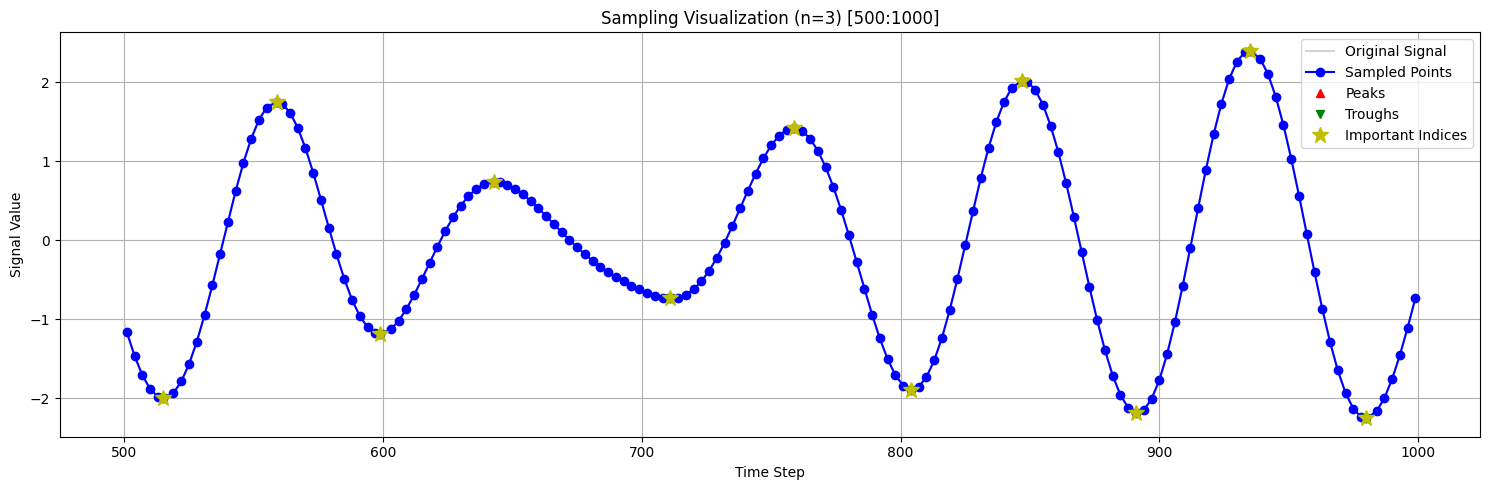

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def visualize_sampling_partial(
    data: np.ndarray,
    sampled_data: np.ndarray,
    sampled_indices: list[int],
    peak_indices: list[int],
    trough_indices: list[int],
    important_indices: list[int],
    start: int = 0,
    end: int = 1000,
    title: str = ""
):
    """
    Visualize sampling results within a partial range [start:end].

    Args:
        data: Original signal.
        sampled_data: Values at sampled_indices (unused but kept for signature consistency).
        sampled_indices: Indices selected by sampling.
        peak_indices: Detected peak positions.
        trough_indices: Detected trough positions.
        important_indices: Combined list of peaks and troughs.
        start: Start index of the range to visualize.
        end: End index of the range to visualize.
        title: Optional title to annotate the plot.
    """
    plt.figure(figsize=(15, 5))

    x = np.arange(len(data))
    view_range = (x >= start) & (x < end)

    # Plot original signal
    plt.plot(x[view_range], data[view_range], label="Original Signal", color="lightgray")

    # Plot sampled points in range
    sampled_in_range = [(i, data[i]) for i in sampled_indices if start <= i < end]
    if sampled_in_range:
        xs, ys = zip(*sampled_in_range)
        plt.plot(xs, ys, 'bo-', label="Sampled Points")

    # Plot peaks and troughs in range
    peaks_in_range = [i for i in peak_indices if start <= i < end]
    troughs_in_range = [i for i in trough_indices if start <= i < end]
    important_in_range = [i for i in important_indices if start <= i < end]

    plt.plot(peaks_in_range, data[peaks_in_range], 'r^', label="Peaks")
    plt.plot(troughs_in_range, data[troughs_in_range], 'gv', label="Troughs")
    plt.plot(important_in_range, data[important_in_range], 'y*', label="Important Indices", markersize=12)

    plt.title(f"Sampling Visualization {title} [{start}:{end}]")
    plt.xlabel("Time Step")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# -----------------------------------------------
# ✅ Sampling & Visualization
# -----------------------------------------------

# 1. Sampling interval
n = 3

# 2. Extract data for file_index == 4 (up to 1000 samples)
test_df_file4 = test_df[test_df["file_index"] == 4].reset_index(drop=True)
signal = test_df_file4["x3(m)"].values[:1000]

# 3. Detect peaks and troughs
peak_indices, _ = find_peaks(signal, distance=50)
trough_indices, _ = find_peaks(-signal, distance=50)
important_indices = np.sort(np.concatenate([peak_indices, trough_indices])).tolist()

# 4. Regular sampling by interval n
sampled_indices = list(range(0, len(signal), n))

# 5. Replace nearest point with important index
for idx in important_indices:
    if idx not in sampled_indices:
        closest = min(sampled_indices, key=lambda x: abs(x - idx))
        sampled_indices.remove(closest)
        sampled_indices.append(idx)
sampled_indices = sorted(sampled_indices)

# 6. Run visualization
visualize_sampling_partial(
    data=signal,
    sampled_data=signal[sampled_indices],
    sampled_indices=sampled_indices,
    peak_indices=peak_indices.tolist(),
    trough_indices=trough_indices.tolist(),
    important_indices=important_indices,
    start=500,
    end=1000,
    title=f"(n={n})"
)


## Save downsampled data

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# Detect peak and trough indices across all multivariate features
def find_peak_and_trough_indices_multivariate(df, distance=50):
    all_indices = set()
    for col in df.columns:
        if col in ["t(s)", "file_index"]:
            continue
        series = df[col].values
        peaks, _ = find_peaks(series, distance=distance)
        troughs, _ = find_peaks(-series, distance=distance)
        all_indices.update(peaks.tolist())
        all_indices.update(troughs.tolist())
    return np.sort(list(all_indices))

# Adjust sampled data to include peak/trough points
def get_adjusted_sampled_data(signal, n, important_indices):
    regular_indices = np.arange(0, len(signal), n)
    final_indices = set(regular_indices.tolist())
    for idx in important_indices:
        if idx not in final_indices:
            closest = min(final_indices, key=lambda x: abs(x - idx))
            final_indices.remove(closest)
            final_indices.add(idx)
    sorted_indices = sorted([idx for idx in final_indices if idx < len(signal)])
    return signal[sorted_indices]

# Save downsampled versions of train/val/test datasets for different downsampling ratios
def save_downsampled_split_datasets(train_df, val_df, test_df, downsample_ratios):
    for n in downsample_ratios:
        print(f"\n💾 Saving downsampled data with interval n={n}")

        if n == 1:
            # No downsampling for n=1 (original data)
            train_down, val_down, test_down = train_df.copy(), val_df.copy(), test_df.copy()
        else:
            # Step 1: Find important peak/trough indices
            train_important = find_peak_and_trough_indices_multivariate(train_df)
            val_important   = find_peak_and_trough_indices_multivariate(val_df)
            test_important  = find_peak_and_trough_indices_multivariate(test_df)

            # Step 2: Apply adjusted sampling
            train_down = pd.DataFrame(
                get_adjusted_sampled_data(train_df.values, n, train_important),
                columns=train_df.columns
            )
            val_down = pd.DataFrame(
                get_adjusted_sampled_data(val_df.values, n, val_important),
                columns=val_df.columns
            )
            test_down = pd.DataFrame(
                get_adjusted_sampled_data(test_df.values, n, test_important),
                columns=test_df.columns
            )

        # Step 3: Save CSV files to ../downsampled_data directory
        downsample_dir = os.path.join("..", "downsampled_data", f"Downsampling{n}")
        os.makedirs(downsample_dir, exist_ok=True)

        train_down.to_csv(os.path.join(downsample_dir, f"train_n{n}.csv"), index=False)
        val_down.to_csv(os.path.join(downsample_dir, f"val_n{n}.csv"), index=False)
        test_down.to_csv(os.path.join(downsample_dir, f"test_n{n}.csv"), index=False)

        print(f"✅ Saved to: {downsample_dir}/[train|val|test]_n{n}.csv")


# Execute downsampling with multiple ratios
save_downsampled_split_datasets(train_df, val_df, test_df, downsample_ratios=[1, 2, 5, 10])
